## Word 2 Vec

In [1]:
from __future__ import division, absolute_import, print_function

from six.moves import urllib, xrange

import tensorflow as tf
import numpy as np
import collections, math, os, random, zipfile

In [2]:
# download the data
url = 'http://mattmahoney.net/dc/'

def download(filename, expected_bytes):
    """
    Download a file if not present, and make sure it's the right size.
    """
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

# download the file
file_ = download('text8.zip', 31344016)

def read_data(filename):
    """
    Parse the file enclosed in the 'filename' zip file into a list of words.
    """
    # unzip the file
    with zipfile.ZipFile(filename) as f:
        # read the data into the 'data' variable
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    # return the data
    return data

words = read_data(file_)
print('data size:', len(words))

Found and verified text8.zip
data size: 17005207


In [3]:
words[0:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [4]:
# build the dictionary and replace rare words with the "UNK" token.
vocabulary_size = 50000

def build_dataset(words):
    # create counts list, set counts for "UNK" token to -1 (undefined)
    count = [['UNK', -1]]
    # add counts of the 49,999 most common tokens in 'words'
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # create the dictionary data structure
    dictionary = {}
    # give a unique integer ID to each token in the dictionary
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # create a list data structure for the data
    data = []
    # keep track of the number of "UNK" token occurrences
    unk_count = 0
    # for each word in our list of words
    for word in words:
        # if its in the dictionary, get its index
        if word in dictionary:
            index = dictionary[word]
        # otherwise, set the index equal to zero (index of "UNK") and increment the "UNK" count
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        # append its index to the 'data' list structure
        data.append(index)
    # set the count of "UNK" in the 'count' data structure
    count[0][1] = unk_count
    # invert the dictionary; it becomes (index, word) key-value pairs
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    # return the data (indices), counts, dictionary, and inverted dictionary
    return data, count, dictionary, reverse_dictionary

# build the datset
data, count, dictionary, reverse_dictionary = build_dataset(words)
# free up some memory
del words
# print out stats
print('most common words (+UNK):', count[:10])
print('sample data:', data[:10], [reverse_dictionary[i] for i in data[:10]])


most common words (+UNK): [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
sample data: [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [5]:
data_index = 0

# generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    # make sure our parameters are self-consistent
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    # create empty batch ndarray using 'batch_size'
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    # create empty labels ndarray using 'batch_size'
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # [ skip_window target skip_window ]
    span = 2 * skip_window + 1
    # create a buffer object for prepping batch data
    buffer = collections.deque(maxlen=span)
    # for each element in our calculated span, append the datum at 'data_index' and increment 'data_index' moduli the amount of data
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # loop for 'batch_size' // 'num_skips'
    for i in range(batch_size // num_skips):
         # target label at the center of the buffer
        target = skip_window
        targets_to_avoid = [skip_window]
        # loop for 'num_skips'
        for j in range(num_skips):
            # loop through all 'targets_to_avoid'
            while target in targets_to_avoid:
                # pick a random index as target
                target = random.randint(0, span - 1)
            # put it in 'targets_to_avoid'
            targets_to_avoid.append(target)
            # set the skip window in the minibatch data
            batch[i * num_skips + j] = buffer[skip_window]
            # set the target in the minibatch labels
            labels[i * num_skips + j, 0] = buffer[target]
        # add the data at the current 'data_index' to the buffer
        buffer.append(data[data_index])
        # increment 'data_index'
        data_index = (data_index + 1) % len(data)
    # return the minibatch data and corresponding labels
    return batch, labels

# get a minibatch
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)

# print out part of the minibatch to the console
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]], '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 6 a
195 term -> 2 of


In [6]:
# hyperparameters
batch_size = 128
embedding_size = 128 # dimension of the embedding vector
skip_window = 1 # how many words to consider to left and right
num_skips = 2 # how many times to reuse an input to generate a label

# we choose random validation dataset to sample nearest neighbors
# here, we limit the validation samples to the words that have a low
# numeric ID, which are also the most frequently occurring words
valid_size = 16 # size of random set of words to evaluate similarity on
valid_window = 100 # only pick development samples from the first 'valid_window' words
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 # number of negative examples to sample

# create computation graph
graph = tf.Graph()

with graph.as_default():
    # input data
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # operations and variables
    # look up embeddings for inputs
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # construct the variables for the NCE loss
    nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each time we evaluate the loss.
    loss = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights, biases=nce_biases,
                     labels=train_labels, inputs=embed, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    # construct the SGD optimizer using a learning rate of 1.0
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # compute the cosine similarity between minibatch examples and all embeddings
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # add variable initializer
    init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [7]:
# steps to train the model
num_steps = 100001
steplist=[]
losslist=[]
with tf.Session(graph=graph) as session:
    # we must initialize all variables before using them
    init.run()
    print('initialized.')
    
    # loop through all training steps and keep track of loss
    average_loss = 0
    for step in xrange(num_steps):
        # generate a minibatch of training data
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        # we perform a single update step by evaluating the optimizer operation (including it
        # in the list of returned values of session.run())
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        # print average loss every 2,000 steps
        if step % 2000 == 0:
            steplist.append(step)
            if step > 0:
                average_loss /= 2000
            # the average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            losslist.append(average_loss)
            average_loss = 0
        
        # computing cosine similarity (expensive!)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                # get a single validation sample
                valid_word = reverse_dictionary[valid_examples[i]]
                # number of nearest neighbors
                top_k = 8
                # computing nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
        
    final_embeddings = normalized_embeddings.eval()

initialized.
Average loss at step  0 :  273.094085693
nearest to system: embouchure, parmenides, ksc, gore, brenner, joplin, properties, operated,
nearest to other: tana, cleansed, pageant, fluorides, freelance, multiplexing, electrons, unbridled,
nearest to when: proportionally, oscillating, cory, vigour, marches, grounding, mountainous, devotion,
nearest to such: portrayals, schaeffer, frequency, gall, wept, generously, notebooks, plaques,
nearest to on: halfway, mcintyre, spyware, seventh, timescales, alex, parks, radians,
nearest to an: cirque, governorship, hemophilia, schoolchildren, bre, francois, hbp, reilly,
nearest to from: aspires, minimum, canarian, offended, alleviate, romany, beech, sovereignty,
nearest to history: integrable, reflects, iconoclastic, shrewd, liberalised, dweller, anderson, waite,
nearest to see: ulcer, attacked, tropes, marchers, shows, discs, oromo, dinners,
nearest to with: fused, cistern, phone, sarabande, audacity, forgeries, investigated, onset,
near

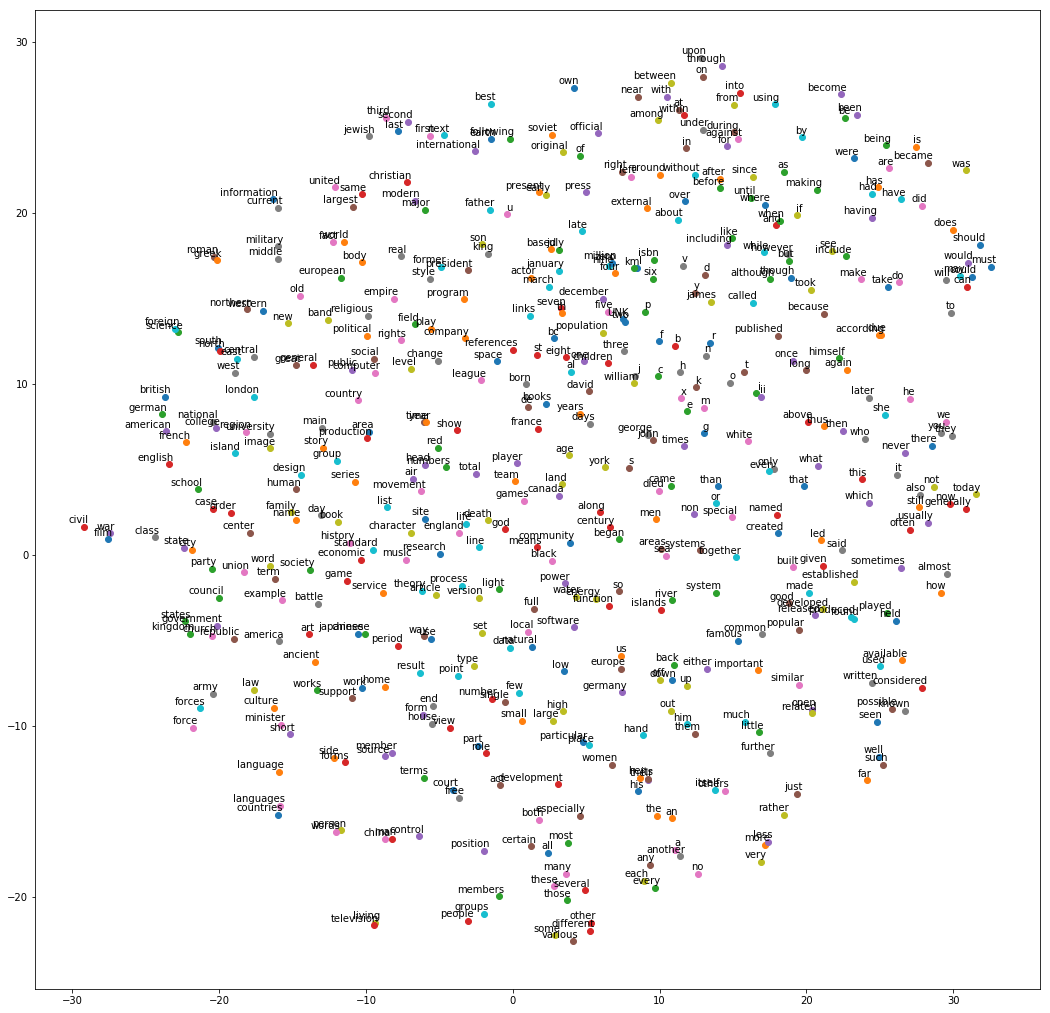

In [8]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # set plot size in inches
    plt.figure(figsize=(18, 18))
    # loop through all labels
    for i, label in enumerate(labels):
        # get the embedding vectors
        x, y = low_dim_embs[i, :]
        # plot them in a scatterplot
        plt.scatter(x, y)
        # annotations
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

    # save the figure out
    plt.savefig(filename)

try:
    # import t-SNE and matplotlib.pyplot
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    
    %matplotlib inline

    # create the t-SNE object with 2 components, PCA initialization, and 5000 iterations
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    # plot only so many words in the embedding
    plot_only = 500
    # fit the TSNE dimensionality reduction technique to the word vector embedding
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    # get the words associated with the points
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    # call the plotting function
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")


In [9]:
    for i in xrange(valid_size):
                # get a single validation sample
                valid_word = reverse_dictionary[valid_examples[i]]
                # number of nearest neighbors
                top_k = 8
                # computing nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

nearest to system: vested, mpd, agouti, hamas, armouries, gpo, naaman, supporter,
nearest to other: various, many, azali, some, different, agouti, abet, slap,
nearest to when: while, if, where, before, after, but, and, though,
nearest to such: well, these, known, specific, many, suicides, abitibi, exported,
nearest to on: in, at, upon, through, during, matrimony, agouti, timescales,
nearest to an: lfar, airplay, bre, the, caliphate, childbirth, bloodshed, bipeds,
nearest to from: in, into, under, during, until, on, at, gaku,
nearest to history: aba, sotho, reflects, voices, music, antoninus, mitral, book,
nearest to see: golfer, include, skiers, microsite, ulcer, but, reginae, akh,
nearest to with: in, between, michelob, pontificia, among, for, eight, or,
nearest to years: weeks, fuelled, toughness, ocean, michelob, days, panspermia, prism,
nearest to than: or, bush, dejima, michelob, excavated, and, victoriae, admirals,
nearest to his: her, their, its, the, s, your, my, upanija,
neare